# Assignment 2 – Behance Like Prediction

## 1. Predictive Task & Evaluation

## 2. Exploratory Data Analysis (EDA)

In [12]:
# --- Core ---
import os, math, random, struct
from collections import defaultdict, Counter

# --- Data ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- ML helpers ---
from sklearn.decomposition import PCA

# --- Utils ---
from tqdm import tqdm
from numpy.linalg import norm

random.seed(0)
np.random.seed(0)

## Data Loading & Preprocessing

### Load appreciates file

In [15]:
data_dir = "data"
path = os.path.join(data_dir, "Behance_appreciate_1M.gz")

triples_raw = []
with open(path, "rt") as f:
    for line in f:
        u, i, t = line.strip().split()
        triples_raw.append((u, i, int(t)))

len(triples_raw), triples_raw[:5]

(1000000,
 [('276633', '01588231', 1307583271),
  ('1238354', '01529213', 1307583273),
  ('165550', '00485000', 1307583337),
  ('2173258', '00776972', 1307583340),
  ('165550', '00158226', 1307583406)])

### Map users/items to integer indices

In [16]:
user2idx, item2idx = {}, {}
idx2user, idx2item = [], []

triples = []  # (u_idx, i_idx, timestamp)

for u, i, t in triples_raw:
    if u not in user2idx:
        user2idx[u] = len(user2idx)
        idx2user.append(u)
    if i not in item2idx:
        item2idx[i] = len(item2idx)
        idx2item.append(i)
    triples.append((user2idx[u], item2idx[i], t))

num_users = len(user2idx)
num_items = len(item2idx)
num_users, num_items, len(triples)

(63497, 178788, 1000000)

### Train / val / test split (per user)

In [17]:
by_user = defaultdict(list)
for u, i, t in triples:
    by_user[u].append((t, i))

train_pos = []
val_pos   = []
test_pos  = []

for u, lst in by_user.items():
    lst.sort()  # sort by time
    if len(lst) >= 3:
        *train_items, val_item, test_item = lst
        train_pos.extend((u, i) for (_, i) in train_items)
        val_pos.append((u, val_item[1]))
        test_pos.append((u, test_item[1]))
    elif len(lst) == 2:
        (t1, i1), (t2, i2) = lst
        train_pos.append((u, i1))
        test_pos.append((u, i2))
    else:
        train_pos.append((u, lst[0][1]))

len(train_pos), len(val_pos), len(test_pos)

(913270, 39171, 47559)

### Users' liked items

In [18]:
user_pos_items = defaultdict(set)
for u, i in train_pos + val_pos + test_pos:
    user_pos_items[u].add(i)

### Negative sampling + eval data builder

In [19]:
def sample_negative(u):
    """Sample an item that user u has NOT liked."""
    while True:
        j = random.randrange(num_items)
        if j not in user_pos_items[u]:
            return j

def build_eval_data(pos_pairs, num_neg=100):
    """
    pos_pairs: list of (u, i_pos).
    Returns: list of dicts: {"u": u, "pos": i_pos, "negs": [neg_items]}
    """
    eval_data = []
    for u, i_pos in pos_pairs:
        negs = [sample_negative(u) for _ in range(num_neg)]
        eval_data.append({"u": u, "pos": i_pos, "negs": negs})
    return eval_data

val_data  = build_eval_data(val_pos,  num_neg=100)
test_data = build_eval_data(test_pos, num_neg=100)

len(val_data), len(test_data)

(39171, 47559)

## 3. Modeling

### Basic stats

In [21]:
num_interactions = len(triples)
print("Users:", num_users)
print("Items:", num_items)
print("Interactions:", num_interactions)
print("Train/Val/Test:", len(train_pos), len(val_pos), len(test_pos))

Users: 63497
Items: 178788
Interactions: 1000000
Train/Val/Test: 913270 39171 47559


### Likes per user

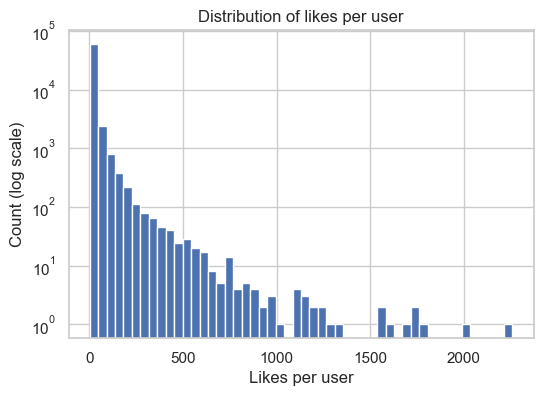

In [22]:
user_counts = Counter(u for u, _, _ in triples)
plt.figure(figsize=(6,4))
plt.hist(list(user_counts.values()), bins=50)
plt.yscale("log")
plt.xlabel("Likes per user")
plt.ylabel("Count (log scale)")
plt.title("Distribution of likes per user")
plt.show()

### Likes per item

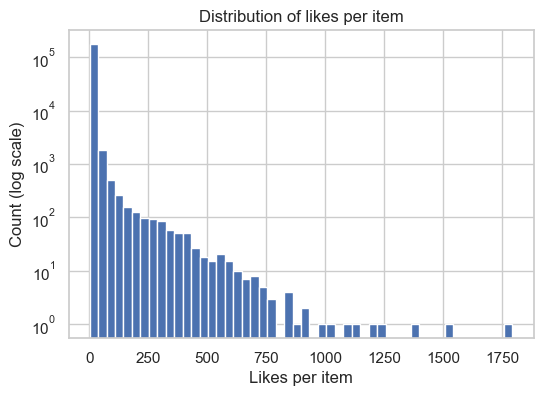

In [23]:
item_counts_full = Counter(i for _, i, _ in triples)
plt.figure(figsize=(6,4))
plt.hist(list(item_counts_full.values()), bins=50)
plt.yscale("log")
plt.xlabel("Likes per item")
plt.ylabel("Count (log scale)")
plt.title("Distribution of likes per item")
plt.show()

## 4. Evaluation & Results

### Evaluation helper

In [24]:
def eval_model(score_fn, eval_data, k=10):
    """
    score_fn(u, i) -> float
    eval_data: list of {"u": u, "pos": i_pos, "negs": [j1,...]}
    Returns: (mean AUC, mean Precision@k)
    """
    aucs = []
    precisions = []

    for row in eval_data:
        u   = row["u"]
        pos = row["pos"]
        negs = row["negs"]

        items = [pos] + negs
        scores = np.array([score_fn(u, it) for it in items])

        pos_score = scores[0]
        neg_scores = scores[1:]

        # AUC = P(score_pos > score_neg)
        auc = np.mean(pos_score > neg_scores)
        aucs.append(auc)

        # Precision@k
        order = np.argsort(-scores)  # descending
        topk = order[:k]
        prec = 1.0 if 0 in topk else 0.0
        precisions.append(prec)

    return float(np.mean(aucs)), float(np.mean(precisions))


### Baseline model – Item popularity

In [25]:
item_counts = Counter(i for (u, i) in train_pos)

def pop_score(u, i):
    # same for all users; uses only item popularity
    return item_counts[i]

### Build MF training data (with negatives)

In [26]:
def build_mf_training_data(num_neg_per_pos=2):
    data = []
    for u, i in train_pos:
        data.append((u, i, 1))
        for _ in range(num_neg_per_pos):
            j = sample_negative(u)
            data.append((u, j, 0))
    random.shuffle(data)
    return data

mf_train_data = build_mf_training_data(num_neg_per_pos=2)
len(mf_train_data)


2739810

### Initialize parameters

In [27]:
K = 40        # latent dimension
lr = 0.05
reg = 0.001
epochs = 5    # start small, increase if training fast

P = 0.01 * np.random.randn(num_users, K)
Q = 0.01 * np.random.randn(num_items, K)

### MF scoring function

In [28]:
def mf_score(u, i):
    return float(P[u] @ Q[i])

### Training loop

In [29]:
def train_mf(train_data, epochs=5, lr=0.05, reg=0.001):
    global P, Q
    for epoch in range(epochs):
        random.shuffle(train_data)
        total_loss = 0.0

        for u, i, y in train_data:
            pred = P[u] @ Q[i]
            p_hat = 1.0 / (1.0 + math.exp(-pred))  # logistic
            grad = p_hat - y                       # d/dpred logloss

            Pu = P[u]
            Qi = Q[i]

            P[u] -= lr * (grad * Qi + reg * Pu)
            Q[i] -= lr * (grad * Pu + reg * Qi)

            total_loss += -(y * math.log(p_hat + 1e-8) +
                            (1 - y) * math.log(1 - p_hat + 1e-8))

        avg_loss = total_loss / len(train_data)
        print(f"Epoch {epoch+1}/{epochs}, avg log-loss: {avg_loss:.4f}")

train_mf(mf_train_data, epochs=epochs, lr=lr, reg=reg)


Epoch 1/5, avg log-loss: 0.6931
Epoch 2/5, avg log-loss: 0.6842
Epoch 3/5, avg log-loss: 0.6169
Epoch 4/5, avg log-loss: 0.5333
Epoch 5/5, avg log-loss: 0.4772


### Load image features

In [30]:
IMG_PATH = os.path.join(data_dir, "Behance_Image_Features.b")
print("Image file exists:", os.path.exists(IMG_PATH))

item_features = {}  # item_idx -> np.array(4096,)

with open(IMG_PATH, "rb") as f:
    while True:
        item_id_bytes = f.read(8)
        if not item_id_bytes:
            break
        raw_id = item_id_bytes.decode("ascii").strip()
        vec = f.read(4 * 4096)
        if len(vec) < 4 * 4096:
            break
        feat = np.frombuffer(vec, dtype=np.float32)

        # map original item ID -> our index
        if raw_id in item2idx:
            idx = item2idx[raw_id]
            item_features[idx] = feat

len(item_features)

Image file exists: True


178787

### Build user visual profiles

In [31]:
user_visual = {}

for u in range(num_users):
    liked = [i for (uu, i) in train_pos if uu == u and i in item_features]
    if not liked:
        continue
    mat = np.stack([item_features[i] for i in liked])
    user_visual[u] = mat.mean(axis=0)

len(user_visual)

63497

### Visual-only scoring function

In [32]:
def visual_score(u, i):
    vu = user_visual.get(u)
    fi = item_features.get(i)
    if vu is None or fi is None:
        return 0.0
    denom = (norm(vu) * norm(fi)) + 1e-8
    return float(vu @ fi / denom)

### Hybrid model (MF + Visual)

In [33]:
def make_hybrid_score(alpha):
    def score(u, i):
        return alpha * mf_score(u, i) + (1 - alpha) * visual_score(u, i)
    return score

### Evaluate on validation set

In [34]:
# Baseline
pop_auc_val, pop_prec_val = eval_model(pop_score, val_data, k=10)
print("Popularity baseline (val): AUC =", pop_auc_val, "P@10 =", pop_prec_val)

# MF
mf_auc_val, mf_prec_val = eval_model(mf_score, val_data, k=10)
print("MF (val): AUC =", mf_auc_val, "P@10 =", mf_prec_val)

# Visual-only
vis_auc_val, vis_prec_val = eval_model(visual_score, val_data, k=10)
print("Visual-only (val): AUC =", vis_auc_val, "P@10 =", vis_prec_val)

# Hybrid with different alphas
alphas = [0.2, 0.5, 0.8]
hyb_val_results = []
for alpha in alphas:
    hyb_score = make_hybrid_score(alpha)
    auc, prec = eval_model(hyb_score, val_data, k=10)
    hyb_val_results.append((alpha, auc, prec))
    print(f"Hybrid alpha={alpha}: AUC={auc:.4f}, P@10={prec:.4f}")

hyb_val_results

Popularity baseline (val): AUC = 0.7457833601388782 P@10 = 0.6277858619897373
MF (val): AUC = 0.7800829695437953 P@10 = 0.598580582573843
Visual-only (val): AUC = 0.6227599499629828 P@10 = 0.2196012356079753
Hybrid alpha=0.2: AUC=0.7981, P@10=0.5484
Hybrid alpha=0.5: AUC=0.8147, P@10=0.6047
Hybrid alpha=0.8: AUC=0.8075, P@10=0.6147


[(0.2, 0.7980618314569452, 0.5483648617599755),
 (0.5, 0.8147249240509562, 0.6046820351790866),
 (0.8, 0.8075075949043936, 0.6147404967960991)]

In [35]:
alpha_best = 0.5
hybrid_best = make_hybrid_score(alpha_best)

In [36]:
pop_auc_test, pop_prec_test = eval_model(pop_score, test_data, k=10)
mf_auc_test,  mf_prec_test  = eval_model(mf_score,  test_data, k=10)
vis_auc_test, vis_prec_test = eval_model(visual_score, test_data, k=10)
hyb_auc_test, hyb_prec_test = eval_model(hybrid_best, test_data, k=10)

results = pd.DataFrame({
    "Model": [
        "Popularity (baseline)",
        "MF",
        "Visual-only",
        f"Hybrid (alpha={alpha_best})"
    ],
    "AUC":  [pop_auc_test, mf_auc_test, vis_auc_test, hyb_auc_test],
    "P@10": [pop_prec_test, mf_prec_test, vis_prec_test, hyb_prec_test],
})
results

,Model,AUC,P@10
0,Popularity (baseline),0.737395,0.621291
1,MF,0.767093,0.584432
2,Visual-only,0.607743,0.207847
3,Hybrid (alpha=0.5),0.796304,0.573057


## 5. Related Work

## 5. Related Work

Our project fits into a long line of research on systems that suggest items to users based on
their past behavior, such as likes or clicks, and on using image information to make better
recommendations.

**Using past likes and clicks to make recommendations:**  
Many existing systems only see whether a user clicked or liked something, not a detailed
rating. Early work such as *Collaborative Filtering for Implicit Feedback Datasets* (Hu,
Koren, & Volinsky, 2008) and *BPR: Bayesian Personalized Ranking from Implicit
Feedback* (Rendle, Freudenthaler, Gantner, & Schmidt-Thieme, 2009) showed how to use
this kind of “yes/no” data to learn which users and items go well together. Their models
learn a small list of numbers for each user and for each item, and then give a higher score
to user–item pairs whose numbers line up well. At prediction time, the system picks the
items with the highest scores for each user. Our main interaction based model is inspired by this
same idea, where for each user and each project, we learn a short numeric description, and to
recommend projects to a user we score all projects and keep the ones with the highest
scores.

**Popularity based recommendations:**  
Other work on sites like YouTube, Pinterest, or Behance-style platforms has found that
simply recommending the most popular items, meaning the ones that receive the most likes overall,
can already work surprisingly well. Because many users interact with only a few items, and
because attention is often focused on a small set of very popular items, “recommend what
is globally popular” is commonly used as a simple starting point or a backup strategy. Our
popularity based model follows this idea, since we rank projects by how many likes they
have, and recommend the top ones to everyone. In our results, this approach is quite effective: 
on average, for each user, a large fraction of the top 10 projects we recommend
this way are projects they actually liked in the held out test data. This supports the claim
from prior work that likes tend to be heavily concentrated on a small set of very popular
projects.

**Using image information to make recommendations:**  
More recent research combines interaction data with information extracted from the images
themselves. In domains like fashion, art, and design, how something looks is very important,
so using image information can help. Models such as VBPR (*VBPR: Visual Bayesian
Personalized Ranking for Personalized Recommendation of Visual Content*; He &
McAuley, 2016) use an image recognition network to turn each image into a long vector of
numbers that captures aspects like style, color, and composition. They then combine this
image based description with the interaction based model so that the system can
recommend items that both match a user’s taste and look similar to things they have liked
before, and can still recommend reasonable items even when there are few past likes for a
given item. Other work on image popularity prediction, such as *What Makes an Image
Popular?* (Khosla, Das Sarma, & Hamid, 2014), also shows that these kinds of image
features are strongly related to whether an image will attract attention and engagement.

Our visual only model is closest to this line of work on image popularity. In our case, we
ignore user IDs and only look at image-based features, since we build a visual profile for each
user by averaging the image features of the projects they liked, and then recommend
projects whose image features are similar to that profile. We find that this image only
approach does contain useful information, but it is not enough by itself: compared to our
interaction-based model and our popularity based model, it suggests fewer projects that
the user actually likes near the top of the ranked list.

**Combining interaction and image information:**  
A common idea in related works is to combine these different signals rather than choose
only one of them. Many papers use a weighted combination of a score based on past
interactions and a score based on content, such as image features. This lets the system
balance between “people who liked X also liked Y” and “this looks similar to what you
liked before,” and can help especially for users or items that do not have much interaction
history. Our combined model follows this pattern, as for each user–project pair, we compute
one score from the interaction based model and one from the image based model, and
then take a weighted average of the two, controlled by a parameter that decides how much
weight to give to each source of information. In line with prior work, we see that using a
middle value for this weight, rather than relying purely on interactions or purely on images,
gives the best overall ranking of projects for most users on our test data. However, our
results also show that the pure popularity based model still gives the largest number of
correct hits in the top 10 recommendations. This suggests that our simple way of combining
signals does not yet fully exploit popularity information, a limitation that is also discussed in
recent work on how to correctly handle very popular items when building recommendation
systems.
